#### Loading Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from itertools import product

#Tests for sample comparison
from scipy.stats import spearmanr
from scipy.stats import shapiro
import scipy.stats as stats
from scipy.stats import mannwhitneyu
from statsmodels.stats.diagnostic import lilliefors

#ARIMA
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from pmdarima import auto_arima


#Prophet
from prophet import Prophet
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import cross_validation

#LightGBM
import lightgbm as lgb
from lightgbm import LGBMRegressor
from lightgbm.callback import early_stopping, log_evaluation

#XGBoost
import xgboost as xgb
from xgboost import plot_importance

#Libraries for tuning NHITS and environment setup
import logging
from ray import tune
from IPython.display import display

#NHITS
from neuralforecast import NeuralForecast
from neuralforecast.models import LSTM, NHITS
from neuralforecast.auto import AutoNHITS, AutoLSTM
from neuralforecast.losses.pytorch import MAE,RMSE,MQLoss

from utilsforecast.plotting import plot_series
from utilsforecast.losses import mse, mae, rmse
from utilsforecast.evaluation import evaluate

#Model Evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score,make_scorer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import TimeSeriesSplit,GridSearchCV,ParameterGrid 
from sklearn.preprocessing import LabelEncoder,StandardScaler

#Model extension
import shap

/home/armandoim/miniconda3/envs/myenv/lib/python3.12/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


#### Loading Data

In [3]:
train_set = pd.read_csv(r"/mnt/c/Users/aimeraj/Desktop/data/train.csv")
stores_set = pd.read_csv(r"/mnt/c/Users/aimeraj/Desktop/data/stores.csv")
oil_set = pd.read_csv(r"/mnt/c/Users/aimeraj/Desktop/data/oil.csv")
holiday_set = pd.read_csv(r"/mnt/c/Users/aimeraj/Desktop/data/holidays_events.csv")
transactions_set =pd.read_csv(r"/mnt/c/Users/aimeraj/Desktop/data/transactions.csv")
test_set = pd.read_csv(r"/mnt/c/Users/aimeraj/Desktop/data/test.csv")

#### Display Options

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows',None)
#αν θελω reset
#pd.reset_option('display.max_columns')

#### Data Preparation

In [ ]:
#ελεγχος για διπλοτυπα
print(train_set.duplicated().sum(),
      stores_set.duplicated().sum(),
      oil_set.duplicated().sum(),
      holiday_set.duplicated().sum(),
      transactions_set.duplicated().sum(),
      test_set.duplicated().sum()
      )

In [ ]:
train_set.head()

In [ ]:
stores_set.head()

In [ ]:
oil_set.head()

In [ ]:
holiday_set.head()

In [ ]:
holiday_set.locale.unique()

In [ ]:
transactions_set.head()

In [ ]:
test_set.head()

In [ ]:
#Merges
df = pd.merge(train_set,stores_set,on='store_nbr',how='left')
df = pd.merge(df,oil_set,on ='date',how='left')
df = pd.merge(df,transactions_set,on=['date','store_nbr'],how='left')

In [ ]:
df.head()

In [ ]:
print(
    f"The dataset contains {df.shape[0]} samples and "
    f"{df.shape[1]} features"
)

In [ ]:
#NaNs Check
df.isna().sum()

In [ ]:
sales_zero = df[df['sales'] == 0]

In [ ]:
sales_zero.isna().sum() # 291028 - 245869 = 45159

In [ ]:
#Transactions NaNs fix
df.loc[df['sales']==0,'transactions']=0
del sales_zero
df['transactions'] = df.groupby('store_nbr')['transactions'].ffill()

In [ ]:
#We note that we dont have the same dates on train_set as oil_set 
print(len(train_set['date'].unique()),len(oil_set['date'].unique()))

In [ ]:
# Turning date to datetime
df['date']= pd.to_datetime(df['date'])
df['day']= df['date'].dt.day_name()
working_days = df[df['date'].dt.dayofweek < 5]

In [ ]:
print(df.loc[df['day'] == 'Saturday', 'dcoilwtico'].isna().sum() +
      df.loc[df['day'] == 'Sunday', 'dcoilwtico'].isna().sum() 
      )

In [ ]:
#We fill the weekend oil prices with their last known price(usually Friday) 
weekend_mask = df['day'].isin(['Saturday', 'Sunday']) & df['dcoilwtico'].isna()
df['price_filled'] = df['dcoilwtico']
df['price_filled'] = df['price_filled'].where(df['day'].isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']))
df['price_filled'] = df['price_filled'].ffill()
df.loc[weekend_mask, 'dcoilwtico'] = df.loc[weekend_mask, 'price_filled']
df.drop(columns=['price_filled'], inplace=True)

In [ ]:
#For the rest of the oil prices we interpolate
df['dcoilwtico'] = df['dcoilwtico'].interpolate(method='linear')
df['dcoilwtico'] = df['dcoilwtico'].bfill()


In [ ]:
holiday_set.isna().sum()

In [ ]:
df.info()

In [ ]:
transactions_set.isna().sum()

In [ ]:
df.isna().sum()

#### Exploratory Data Analysis

In [ ]:
df.head()

In [ ]:
print(
    f"The dataset contains {df.shape[0]} samples and "
    f"{df.shape[1]} features"
)

In [ ]:
len(df['store_nbr'].unique())

In [ ]:
df['family'].unique()

In [ ]:
len(df['family'].unique())

In [ ]:
df['city'].unique()

In [ ]:
len(df['city'].unique())

In [ ]:
df['state'].unique()

In [ ]:
len(df['state'].unique())

In [ ]:
df['type'].unique()

In [ ]:
df['cluster'].unique()

In [ ]:
df['day'].unique()

In [ ]:
df[['sales','onpromotion','transactions','dcoilwtico']].describe()

In [ ]:
# Here I create a chart of sales over time
# To do this, I need to sum the sales for each day,
# since the existing dataset contains sales for all individual days and all stores
daily_sales = df[['date','sales']].copy()
daily_sales = daily_sales.groupby('date').sum().reset_index()


In [ ]:
px.line(daily_sales,x='date',y='sales',title="Daily Sales")

In [ ]:
#Merging oil prices with daily sales to do correlation test
daily_oil = df[['date', 'dcoilwtico']].dropna().drop_duplicates(subset='date')
daily_df = pd.merge(daily_sales,daily_oil,on='date',how='left')
daily_df.head()

In [ ]:
moving_average = daily_df['sales'].rolling(
    window = len(daily_df['sales']),
    center = True,
    min_periods = len(daily_df['sales'])//2,
).mean()

daily_df['moving_average'] = moving_average

In [ ]:
fig1 = px.scatter(daily_df, x='date', y='sales')
fig2 = px.line(daily_df, x='date', y='moving_average', color_discrete_sequence=['red'])
fig3 = go.Figure(data=fig1.data + fig2.data)
fig3 = fig3.update_layout(xaxis_title="Sales", yaxis_title="Date", title = 'Moving Average Over Time')
fig3.show()

In [ ]:
df['year'] = df['date'].dt.year
avg_sales_year_family = df.groupby(['year', 'family'])['sales'].mean().reset_index()

In [ ]:
fig = px.line(
    avg_sales_year_family,
    x='year',
    y='sales',
    color='family',
    facet_col='family',
    facet_col_wrap=4,
    markers=True,
    title='Average Yearly Sales per Product Family'
)

# Don't match y-axes between facets
fig.update_yaxes(matches=None)

# Show y-axis on every subplot
fig.for_each_yaxis(lambda y: y.update(showticklabels=True, showline=True, ticks="outside"))
fig.for_each_xaxis(lambda x: x.update(showticklabels=True, showline=True, ticks="outside"))

fig.update_layout(
    showlegend=False,
    height=2000,
    width=1400,
    title_x=0.5
)

fig.show()



In [ ]:
df['month'] = df['date'].dt.month
df['month_name'] = df['date'].dt.strftime('%B')
avg_sales_by_month = df.groupby(['month', 'month_name', 'family'])['sales'].mean().reset_index()

avg_sales_by_month = avg_sales_by_month.sort_values('month')

In [ ]:
fig = px.line(
    avg_sales_by_month,
    x='month_name',
    y='sales',
    color='family',
    facet_col='family',
    facet_col_spacing=0.1,
    facet_col_wrap=4,
    markers=True,
    category_orders={"month_name": [
        "January", "February", "March", "April", "May", "June",
        "July", "August", "September", "October", "November", "December"
    ]},
    title='Average Sales by Calendar Month per Product Family'
)
fig.update_yaxes(matches=None)

# Show y-axis on every subplot
fig.for_each_yaxis(lambda y: y.update(showticklabels=True, showline=True, ticks="outside"))
fig.for_each_xaxis(lambda x: x.update(showticklabels=True, showline=True, ticks="outside"))

fig.update_layout(
    showlegend=False,
    height=2000,
    width=1400,
    title_x=0.5
)
# fig.update_yaxes(matches=None)
# fig.update_layout(height=2000,showlegend=False)

# fig.update_layout(
#     xaxis_title='Month',
#     yaxis_title='Average Sales',
#     legend_title='Family',
#     width=1000,
#     height=600
# )

fig.show()


In [ ]:
df['day_nbr'] = df['date'].dt.weekday
avg_sales_by_weekday = df.groupby(['day_nbr', 'day', 'family'])['sales'].mean().reset_index()

In [ ]:
avg_sales_by_weekday = avg_sales_by_weekday.sort_values('day_nbr')
fig = px.line(
    avg_sales_by_weekday,
    x='day',
    y='sales',
    color='family',
    facet_col='family',
    facet_col_wrap=4,
    markers=True,
    category_orders={"day": [
        "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"
    ]},
    title='Average Sales by Day of Week per Product Family'
)

# fig.update_yaxes(matches=None)
# fig.update_layout(height=2000,showlegend=False)

fig.update_yaxes(matches=None)

# Show y-axis on every subplot
fig.for_each_yaxis(lambda y: y.update(showticklabels=True, showline=True, ticks="outside"))
fig.for_each_xaxis(lambda x: x.update(showticklabels=True, showline=True, ticks="outside"))

fig.update_layout(
    showlegend=False,
    height=2000,
    width=1400,
    title_x=0.5
)

fig.show()


In [ ]:
t = df.groupby("family")['sales'].mean().sort_values(ascending=False).reset_index()
px.bar(t,y='family',x='sales',color='family',title='Average sales per product family')

In [ ]:
t = df.groupby("city")['sales'].mean().sort_values(ascending=False).reset_index()
px.bar(t,y='city',x='sales',color='city',title='Average sales per City')

In [ ]:
# temp = df[["store_nbr", "sales"]].copy()
# temp["ind"] = 1
# temp["ind"] = temp.groupby("store_nbr")["ind"].cumsum().values
# pivot_sales = pd.pivot(temp, index="ind", columns="store_nbr", values="sales")

# corr_matrix = pivot_sales.corr()
# mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# plt.figure(figsize=(20, 20))
# sns.heatmap(corr_matrix,
#             annot=True,
#             fmt='.1f',
#             cmap='coolwarm',
#             square=True,
#             mask=mask,
#             linewidths=1,
#             cbar=False)
# plt.title("Correlations among stores", fontsize=20)
# plt.show()

#### Oil Price - Impact on Sales

In [ ]:

px.line(daily_oil,x='date',y='dcoilwtico',title='Daily Price of Oil Over Time')

In [ ]:
import matplotlib.pyplot as plt

plt.hist(daily_df['sales'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Daily Sales')  # <-- Add title here
plt.xlabel('Sales')                      # Optional: label x-axis
plt.ylabel('Frequency')                  # Optional: label y-axis
plt.show()


In [ ]:
plt.hist(daily_df['dcoilwtico'],bins=30, color='skyblue', edgecolor='black');
plt.title('Distribution of Daily Oil Price')  # <-- Add title here
plt.xlabel('Oil Price')                      # Optional: label x-axis
plt.ylabel('Frequency')                  # Optional: label y-axis
plt.show()

In [ ]:
corr, p_value = spearmanr(daily_df['sales'], daily_df['dcoilwtico'])

print(f"Spearman correlation: {corr}")
print(f"P-value: {p_value}")

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

plt.figure(figsize=(10, 6))
plt.scatter(daily_df['dcoilwtico'], daily_df['sales'], alpha=0.5)
plt.title('Sales ~ Oil Price')
plt.xlabel('dcoilwtico')
plt.ylabel('sales')
plt.grid(True)

# Απενεργοποιεί την επιστημονική σημειογραφία στον y-axis
plt.gca().yaxis.set_major_formatter(ScalarFormatter(useMathText=False))
plt.ticklabel_format(style='plain', axis='y')  # <-- εναλλακτικά ή επιπρόσθετα

plt.show()



#### OnPromotion - Impact on Sales

In [ ]:
corr, p_value = spearmanr(df['sales'], df['onpromotion'])

print(f"Spearman correlation: {corr}")
print(f"P-value: {p_value}")


In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(df['onpromotion'],df['sales'], alpha=0.5)
plt.title('Sales ~ Onpromotion')
plt.xlabel('Onpromotion')
plt.ylabel('sales')
plt.grid(True)
plt.show()

#### Earthquake - Impact on Sales

In [ ]:
daily_df["date"] = pd.to_datetime(daily_df["date"])
before = daily_df[(daily_df["date"] >= '2016-03-01') & (daily_df["date"] <= '2016-04-15')]
after = daily_df[(daily_df["date"] >= '2016-04-16') & (daily_df["date"] <= '2016-05-31')]

In [ ]:
plt.hist(before['sales'], bins=30, color='skyblue', edgecolor='black');


In [ ]:
plt.hist(after['sales'], bins=30, color='skyblue', edgecolor='black');


In [ ]:
stat, p_value = mannwhitneyu(before['sales'], after['sales'])

print(f"U statistic: {stat}")
print(f"P-value: {p_value}")

In [ ]:
before[['sales']].describe()

In [ ]:
after[['sales']].describe()

In [ ]:
df[['sales']].describe()

In [ ]:
del avg_sales_by_month,avg_sales_by_weekday,avg_sales_year_family,moving_average,daily_df,daily_oil,daily_sales
del train_set,oil_set,transactions_set,before,after,weekend_mask
del fig,fig1,fig2,fig3,working_days,

In [ ]:
df.shape

In [ ]:
holiday_set['date'] = pd.to_datetime(holiday_set['date'])
holiday_set[holiday_set['transferred']==True]

In [ ]:
#Fixing transfers at holiday_set
temp1 = holiday_set[(holiday_set['type']=='Holiday')& (holiday_set['transferred']==True)].drop('transferred',axis=1).reset_index(drop=True)
temp2 = holiday_set[(holiday_set['type']=='Transfer')].drop('transferred',axis=1).reset_index(drop=True)
temp = pd.concat([temp1,temp2],axis=1)
temp = temp.iloc[:,[5,1,2,3,4,]]
holiday_set = holiday_set[(holiday_set['type']!='Transfer')& (holiday_set['transferred']==False)].drop('transferred',axis=1)
holiday_set = pd.concat([holiday_set, temp]).reset_index(drop=True)
del temp,temp1,temp2

In [ ]:
#Keeping a copy because Prophet needs a specific format for Holidays
holidays_for_prophet = holiday_set.copy()
holidays_for_prophet= holidays_for_prophet.drop(['type','locale_name','locale'],axis=1)

In [ ]:
holiday_set['type']= np.where(holiday_set['type']=='Additional','Holiday',holiday_set['type'])
holiday_set['type']= np.where(holiday_set['type']=='Bridge','Holiday',holiday_set['type'])

In [ ]:
work_days_left = holiday_set[holiday_set.type=='Work Day']
holiday_set = holiday_set[holiday_set.type!='Work Day']

In [ ]:
events = holiday_set[holiday_set.type=='Event'].drop(['type','locale','locale_name'],axis=1)
events= events.rename({"description":"event"},axis=1)
holiday_set = holiday_set[holiday_set.type!='Event'].drop("type",axis=1)

In [ ]:
regional = holiday_set[holiday_set['locale']=='Regional'].rename({"locale_name":"state","description":"holiday_regional"},axis=1).drop("locale",axis=1).drop_duplicates()
national = holiday_set[holiday_set['locale']=='National'].rename({"description":"holiday_national"},axis=1).drop(["locale","locale_name"],axis=1).drop_duplicates()
local = holiday_set[holiday_set['locale']=='Local'].rename({"locale_name":"city","description":"holiday_local"},axis=1).drop("locale",axis=1).drop_duplicates()

In [ ]:
events['date'] = pd.to_datetime(events['date'])
national['date'] = pd.to_datetime(national['date'])
regional['date'] = pd.to_datetime(regional['date'])

In [ ]:
print(events[events['date'].duplicated()])


In [ ]:
print(national[national['date'].duplicated()])


In [ ]:
print(local[local['date'].duplicated()])


In [ ]:
# Check for duplicates
print(national['date'].duplicated().sum())         
print(regional.duplicated(['date', 'state']).sum()) 
print(local.duplicated(['date', 'city']).sum())     
print(events['date'].duplicated().sum())           


In [ ]:
events = events.drop_duplicates(subset=['date'])
national= national.drop_duplicates(subset=['date'])
local= local.drop_duplicates(subset=['date','city'])

In [ ]:
events['date'] = pd.to_datetime(events['date'])
national['date'] = pd.to_datetime(national['date'])
regional['date'] = pd.to_datetime(regional['date'])
df = pd.merge(df,national,how='left',on='date')
df = pd.merge(df,regional,how='left',on=['date',"state"])
df = pd.merge(df,local,how='left',on=['date',"city"])
df = pd.merge(df,events,on=['date'],how='left')


In [ ]:
#Creating a test_df with the provided test_set from Kaggle to create the future predictions
test_set['date'] = pd.to_datetime(test_set['date'])
test_df = pd.merge(test_set,stores_set,on='store_nbr',how='left')
test_df = pd.merge(test_df,national,how='left',on='date')
test_df = pd.merge(test_df,regional,how='left',on=['date',"state"])
test_df = pd.merge(test_df,local,how='left',on=['date',"city"])
test_df = pd.merge(test_df,events,on=['date'],how='left')

In [ ]:
#We check if all the dates are contianted in the dataset 
# Generate complete date range from min to max
full_range = pd.date_range(start=df['date'].min(), end=df['date'].max())

# Get unique dates from your data
present_dates = df['date'].drop_duplicates()

# Find missing dates
missing_dates = full_range.difference(present_dates)

# Output missing dates
print("Missing dates:")
print(missing_dates)

In [ ]:
# In the next 3 cells we create the 4 missing dates for Christmas and we fill them accordingly
#Christmas will be treated as event
missing_df = pd.DataFrame({'date': missing_dates})
store_family_combos = df[['store_nbr', 'family', 'city', 'state', 'cluster','type']].drop_duplicates()
missing_df = pd.DataFrame([(d, *row) for d in missing_dates for row in store_family_combos.itertuples(index=False)],
                          columns=['date', 'store_nbr', 'family', 'city', 'state', 'cluster','type'])
missing_df['id'] = range(3000888, 3000888 + len(missing_df))
missing_df['sales'] = 0
missing_df['onpromotion'] = 0
missing_df['transactions'] = 0
missing_df['day'] = missing_df['date'].dt.day
missing_df['month'] = missing_df['date'].dt.month
missing_df['year'] = missing_df['date'].dt.year
missing_df['month_name'] = missing_df['date'].dt.month_name()
missing_df['day_nbr'] = missing_df['date'].dt.weekday
missing_df['holiday_national'] = 'no_holiday'
missing_df['holiday_regional'] = 'no_holiday'
missing_df['holiday_local'] = 'no_holiday'
missing_df['event'] = 'Christmas'

In [ ]:
dates = ['2013-12-24', '2014-12-24', '2015-12-24', '2016-12-24']
df[df['date'].isin(pd.to_datetime(dates))].drop_duplicates(subset=['date'])

In [ ]:
missing_df['dcoilwtico'] = 0
missing_df['dcoilwtico'] = missing_df['dcoilwtico'].astype(float)
missing_df.loc[missing_df['date'] == '2013-12-25', 'dcoilwtico'] = 98.87
missing_df.loc[missing_df['date'] == '2014-12-25', 'dcoilwtico'] = 55.70
missing_df.loc[missing_df['date'] == '2015-12-25', 'dcoilwtico'] = 37.62
missing_df.loc[missing_df['date'] == '2016-12-25', 'dcoilwtico'] = 52.01

In [ ]:
df.shape

In [ ]:
missing_df.shape

In [ ]:
df= pd.concat([df, missing_df]).reset_index(drop=True)

In [ ]:
del missing_dates,missing_df

In [ ]:
df["holiday_national_binary"] = np.where(df["holiday_national"].notnull(),1,0)
df["holiday_regional_binary"] = np.where(df["holiday_regional"].notnull(),1,0)
df["holiday_local_binary"] = np.where(df["holiday_local"].notnull(),1,0)

In [ ]:
test_df["holiday_national_binary"] = np.where(test_df["holiday_national"].notnull(),1,0)
test_df["holiday_regional_binary"] = np.where(test_df["holiday_regional"].notnull(),1,0)
test_df["holiday_local_binary"] = np.where(test_df["holiday_local"].notnull(),1,0)

In [ ]:
encoded_events= pd.get_dummies(events,"event",dtype=int)
encoded_events.columns=encoded_events.columns.str.replace(" ","_")
encoded_events.columns=encoded_events.columns.str.replace(":","_")
encoded_events.columns=encoded_events.columns.str.replace("+","_")
encoded_events.columns=encoded_events.columns.str.replace("-","_")
df = pd.merge(df,encoded_events,how='left',on='date')
test_df= pd.merge(test_df,encoded_events,how='left',on='date')
del encoded_events,events

In [ ]:
df['event'] = df['event'].fillna('no_event')
df['holiday_national'] = df['holiday_national'].fillna('no_holiday')
df['holiday_regional'] = df['holiday_regional'].fillna('no_holiday')
df['holiday_local'] = df['holiday_local'].fillna('no_holiday')
event_cols = [col for col in df.columns if col.startswith('event')]
event_cols.remove('event')
df[event_cols] = df[event_cols].fillna(0).astype(int)

In [ ]:
test_df['event'] = test_df['event'].fillna('no_event')
test_df['holiday_national'] = test_df['holiday_national'].fillna('no_holiday')
test_df['holiday_regional'] = test_df['holiday_regional'].fillna('no_holiday')
test_df['holiday_local'] = test_df['holiday_local'].fillna('no_holiday')
test_df[event_cols] = test_df[event_cols].fillna(0).astype(int)

In [ ]:
test_df['day_of_month'] = test_df['date'].dt.day
test_df['day_nbr'] = test_df['date'].dt.dayofweek
test_df['month'] = test_df['date'].dt.month             # 1–12
test_df['year'] = test_df['date'].dt.year
test_df['is_saturday'] = (test_df['day_nbr'] == 5).astype(int)
test_df['is_sunday'] = (test_df['day_nbr'] == 6).astype(int)
test_df['weekofyear'] = test_df['date'].dt.isocalendar().week.astype(int)
test_df['dayofyear'] = test_df['date'].dt.dayofyear

In [ ]:
# df['day_of_month'] = df['date'].dt.day
# df['day_nbr'] = df['date'].dt.dayofweek
# df['month'] = df['date'].dt.month             # 1–12
# df['year'] = df['date'].dt.year
# df['is_saturday'] = (df['day_nbr'] == 5).astype(int)
# df['is_sunday'] = (df['day_nbr'] == 6).astype(int)
# df['weekofyear'] = df['date'].dt.isocalendar().week.astype(int)
# df['dayofyear'] = df['date'].dt.dayofyear

In [ ]:
# #AB_Test function to determine if an event is statistically important or not 
# def AB_Test(d,group,target):
#     groupA = d[d[group] == 1][target]
#     groupB = d[d[group] == 0][target]
#     if(len(groupA)<50):
#         t1 = shapiro(groupA)[1] < 0.05
#     else:
#         t1 = lilliefors(groupA)[1] < 0.05
    
#     if(len(groupB)<50):
#         t2 = shapiro(groupB)[1] < 0.05
#     else:
#         t2 = lilliefors(groupB)[1] < 0.05
    
#     if (t1 == False) & (t1 == False):
#         leveneTest = stats.levene(groupA, groupB)[1] < 0.05
        
#         if leveneTest == False:
#             ttest = stats.ttest_ind(groupA, groupB, equal_var=True)[1]

#         else:
#             ttest = stats.wilcoxon(groupA, groupB, equal_var=False)[1]

#     else:
#         ttest = stats.mannwhitneyu(groupA, groupB)[1] 

#     temp = pd.DataFrame({
#         "variable":[group],
#         "p-value":[ttest]
#     })
#     return temp

# results = []
#Running the function with a loop for each holiday flag 
# for i in ['holiday_national_binary','holiday_regional_binary','holiday_local_binary']:
#     results.append(AB_Test(d=df[df['sales'].notnull()],group=i,target='sales'))

# results = pd.concat(results)

In [ ]:
#results

In [ ]:
#Doing a loop for events also 
# results=[]
# for i in event_cols:
#     results.append(AB_Test(d=df[df['sales'].notnull()],group=i,target='sales'))
# results = pd.concat(results)
# results

In [ ]:
# results.loc[results['p-value']>0.05,]
# del results

In [ ]:
#Creating unique_id, its a combination of store_nbr and product family
df['unique_id'] = df['store_nbr'].astype(str) + '_' + df['family']
test_df['unique_id'] = test_df['store_nbr'].astype(str) + '_' + df['family']

In [ ]:
#Zero forecasting
zero_sales = df[['unique_id','sales']].copy()
zero_sales=zero_sales.groupby(['unique_id']).sum().reset_index()
zero_sales=zero_sales[zero_sales['sales']==0]

In [ ]:
#zero_sales

In [ ]:
zero_sales.shape # Based on this 53 unique_id have 0 sales and will be droped

In [ ]:
# zero_sales_by_day = df[df['sales'] == 0].groupby('day').size()
# total_by_day = df.groupby('day').size()
# zero_sales_rate = zero_sales_by_day / total_by_day

In [ ]:
# zero_sales_by_day.plot(kind='bar', title='Number of Zero Sales by Day of Week')
# plt.xlabel('Day of Week')
# plt.ylabel('Number of Zero Sales')
# plt.show()

In [ ]:
avg_sales_per_uid = df.groupby('unique_id')['sales'].mean().reset_index()
avg_sales_per_uid.columns = ['unique_id', 'avg_sales']
avg_sales_per_uid.sort_values(by='avg_sales', ascending=False, inplace=True)

In [ ]:
avg_sales_per_uid[avg_sales_per_uid['unique_id'] == '1_CLEANING']


In [ ]:
zero_sales = df[['unique_id','sales']].copy()
zero_sales=zero_sales.groupby(['unique_id']).sum().reset_index()

In [ ]:
zero_sales.sales.describe()

In [ ]:
df.tail()

In [ ]:
df = df.sort_values(by=['store_nbr', 'family', 'date'])

In [ ]:
df.shape

In [ ]:
del stores_set

#### Models

In [ ]:
#ARIMA #44_GROCERY I

In [ ]:
# # # #Extract Series

# my_series = df[df['unique_id'] == '48_GROCERY I'].copy()

In [ ]:
# my_series.shape

In [ ]:
# my_series = my_series.drop([
#     'id',
#     'store_nbr',
#     'family',
#     'onpromotion',
#     'city',
#     'state',
#     'type',
#     'cluster',
#     'dcoilwtico',
#     'transactions',
#     'day',
#     'year',
#     # 'month',
#     'month_name',
#     # 'day_nbr', 
#     'holiday_national',
#     'holiday_regional',
#     'holiday_local', 
#     'event',
#     'unique_id'],axis=1)

In [ ]:
# my_series.set_index('date', inplace=True)
# my_series = my_series.asfreq('D') 
# my_series.shape

In [ ]:
# result = seasonal_decompose(my_series['sales'],period=7)
# result.plot();

In [ ]:
# def adf_test(series,title=''):
#     """
#     Pass in a time series and an optional title, returns an ADF report
#     """
#     print(f'Augmented Dickey-Fuller Test: {title}')
#     result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
#     labels = ['ADF test statistic','p-value','# lags used','# observations']
#     out = pd.Series(result[0:4],index=labels)

#     for key,val in result[4].items():
#         out[f'critical value ({key})']=val
        
#     print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
#     if result[1] <= 0.05:
#         print("Strong evidence against the null hypothesis")
#         print("Reject the null hypothesis")
#         print("Data has no unit root and is stationary")
#     else:
#         print("Weak evidence against the null hypothesis")
#         print("Fail to reject the null hypothesis")
#         print("Data has a unit root and is non-stationary")

In [ ]:
# adf_test(my_series['sales'])

In [ ]:
# auto_arima(my_series['sales'],seasonal=True,m=7,trace=True,error_action='ignore',suppress_warnings=True,stepwise=True).summary() 

In [ ]:
# forecast_start_date = '2017-07-17'
# train_arima = my_series[my_series.index < forecast_start_date]
# test_arima = my_series[my_series.index >= forecast_start_date]

In [ ]:
# exog_train = train_arima.drop(columns=['sales'])
# exog_test = test_arima.drop(columns=['sales'])

In [ ]:
# # model = SARIMAX(np.log1p(train_arima['sales']),exog=exog_train,order=(2,1,0),sesonal_order=(1,0,1,7),enforce_invertibility=False) 
# model = SARIMAX(train_arima['sales'],exog=exog_train,order=(5,1,0),seasonal_order=(2,0,0,7),enforce_invertibility=False)  # ayto krathsa 18/5

In [ ]:
# results = model.fit()
# results.summary()

In [ ]:
# # Obtain predicted values
# start=len(train_arima)
# end=len(train_arima)+len(test_arima)-1
# exog_forecast = exog_test.copy()
# predictions = results.predict(start=start, end=end, exog=exog_test).rename('SARIMAX(5, 1, 0)(2, 0, 0, 7)Predictions')
# # pred = np.expm1(predictions)
# pred = predictions
# # Plot predictions against known values
# title='Sales of 48_GROCERY I'
# ylabel='Sales per day'
# xlabel=''

# ax = test_arima['sales'].plot(legend=True,figsize=(12,6),title=title)
# pred.plot(legend=True)
# ax.autoscale(axis='x',tight=True)
# ax.set(xlabel=xlabel, ylabel=ylabel);

In [ ]:
# error1x = mean_squared_error(test_arima['sales'], pred)
# error2x = np.sqrt(error1x)
# # Print new SARIMAX values
# print(f'SARIMAX(5, 1, 0)(2, 0, 0, 7) R2: {r2_score(test_arima['sales'], pred)}')
# print(f'SARIMAX(5, 1, 0)(2, 0, 0, 7) MSE Error: {error1x:11.10}')
# print(f'SARIMAX(5, 1, 0)(2, 0, 0, 7) RMSE Error: {error2x:11.10}')


In [ ]:
# model = SARIMAX(train_arima['sales'],exog=exog_train[['month','event_Dia_de_la_Madre','event_Cyber_Monday','holiday_local_binary','holiday_national_binary']],order=(5,0,1),seasonal_order=(1,1,1,7),enforce_invertibility=False)
# results = model.fit()
# results.summary()

In [ ]:
# # Obtain predicted values
# start=len(train_arima)
# end=len(train_arima)+len(test_arima)-1
# exog_forecast = exog_test[['month','event_Dia_de_la_Madre','event_Cyber_Monday','holiday_local_binary','holiday_national_binary']].copy()
# predictions = results.predict(start=start, end=end, exog=exog_forecast).rename('SARIMAX(5, 0, 1)(1, 1, 1, 7)Predictions')
# in_sample_preds = predictions

# # Plot predictions against known values
# title='Sales of 48_GROCERY I'
# ylabel='Sales per day'
# xlabel=''

# ax = test_arima['sales'].plot(legend=True,figsize=(12,6),title=title)
# predictions.plot(legend=True)
# ax.autoscale(axis='x',tight=True)
# ax.set(xlabel=xlabel, ylabel=ylabel);

In [ ]:

# error1x = mean_squared_error(test_arima['sales'], predictions)
# error2x = np.sqrt(error1x)

# # Print new SARIMAX values
# print(f'SARIMAX(5,0,1)(1,1,1,7) MSE Error: {error1x:11.10}')
# print(f'SARIMAX(5,0,1)(1,1,1,7) RMSE Error: {error2x:11.10}')
# print(f'SARIMAX(5,0,1)(1,1,1,7) R2: {r2_score(test_arima['sales'], predictions)}')

In [ ]:

# # Step 1: Train model (already done)
# # Step 2: Prepare future exog

# my_series_test_df = test_df[test_df['unique_id'] == '48_GROCERY I'].copy()
# exog_forecast = my_series_test_df[['month','event_Dia_de_la_Madre','event_Cyber_Monday','holiday_local_binary','holiday_national_binary']]

# # Step 3: Set forecast range
# start = len(train_arima)
# end = start + len(my_series_test_df) - 1
# end = start + len(my_series_test_df) - 1

# # Step 4: Forecast
# predictions = results.predict(start=start, end=end, exog=exog_forecast)
# future_preds = predictions
# # Step 5: Assign index if needed
# predictions.index = pd.to_datetime(my_series_test_df['date'])

# # Step 6: Plot
# ax = predictions.plot(figsize=(12,6), legend=True, title='Forecast of 48_GROCERY I')
# ax.set(xlabel='', ylabel='Sales per day');

In [ ]:
# import matplotlib.pyplot as plt

# plt.figure(figsize=(14, 6))
# plt.plot(test_arima.index, test_arima['sales'], label='Actual Sales', color='blue')
# plt.plot(in_sample_preds.index, in_sample_preds, label='Predicted (Test Period)', color='orange')
# plt.plot(future_preds.index, future_preds, label='Forecast (Future)', color='green')

# plt.title('Sales Forecast for 48_GROCERY I')
# plt.ylabel('Sales per day')
# plt.xlabel('')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

In [ ]:
# # Assuming you're working with a time series like:
# series = train_arima['sales']

# # Plot ACF
# plot_acf(series, lags=40)
# plt.title("ACF Plot")
# plt.show()

# # Plot PACF
# plot_pacf(series, lags=40, method='ywm')  # 'ywm' is preferred for stability
# plt.title("PACF Plot")
# plt.show()


In [ ]:
#Prophet

In [ ]:
# agg_df = df.groupby(['date','unique_id']).agg({'sales':'sum'}).reset_index().sort_values(['unique_id','date'])
# total_sales_df = agg_df.pivot(index='date',columns='unique_id', values='sales')

In [ ]:
# total_sales_df.head()

In [ ]:
# changepoint_prior_scale_range = np.linspace(0.001, 0.5, num=5).tolist()
# seasonality_prior_scale_range = np.linspace(0.01, 10, num=5).tolist()
# holidays_prior_scale_range = np.linspace(0.01, 10, num=5).tolist()

In [ ]:
# total_sales_df.shape

In [ ]:
def calculate_mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero = y_true != 0
    return np.mean(np.abs((y_true[non_zero] - y_pred[non_zero]) / y_true[non_zero])) * 100

In [ ]:
# def find_params_Prophet(feature='1_AUTOMOTIVE'):
  
#     category_df = total_sales_df[feature].copy().reset_index()
#     category_df.columns = ["ds", "y"]

#     category_df[["y"]] = category_df[["y"]].apply(pd.to_numeric)
#     category_df["ds"] = pd.to_datetime(category_df["ds"])
    
#     param_grid = {  
#         "changepoint_prior_scale": changepoint_prior_scale_range,
#         "seasonality_prior_scale": seasonality_prior_scale_range,}

#     # Generate all combinations of parameters
#     all_params = [dict(zip(param_grid.keys(), v)) for v in product(*param_grid.values())]
#     rmses = [] 

#     # Use cross validation to evaluate all parameters
#     for params in all_params:
#         m = Prophet(**params).fit(category_df)  # Fit model with given params
#         df_cv = cross_validation(m, initial="365 days", period="30 days", horizon = "30 days")
#         df_p = performance_metrics(df_cv, rolling_window=1)
#         print(df_p)
#         rmses.append(df_p["rmse"].values[0])

#     # Find the best parameters
#     tuning_results = pd.DataFrame(all_params)
#     tuning_results["rmse"] = rmses
    
#     print(feature)
#     print(tuning_results.head())

#     params_dict = dict(tuning_results.sort_values("rmse").reset_index(drop=True).iloc[0])
#     params_dict["column"] = feature 
    
#     return params_dict

In [ ]:
# a = find_params_Prophet('1_CLEANING')

In [ ]:
# b = find_params_Prophet('48_GROCERY I')

In [ ]:
# prediction_days = 30
# forecast_start_date = '2017-07-17'
# def make_preds_Prophet(feature='1_AUTOMOTIVE',dicts={}):
#     category_df = total_sales_df[feature].copy().reset_index()
#     category_df.columns = ['date','y']
#     category_df[['y']] = category_df[['y']].apply(pd.to_numeric)
#     category_df["date"] = pd.to_datetime(category_df["date"])

#     temp = df[df['unique_id'] == feature].copy()

#     temp = temp.drop(['id', 'store_nbr', 'family',
#         'sales','city','state', 'type', 'cluster',
#         'dcoilwtico', 'transactions','day','month_name',
#         'holiday_national','holiday_regional',
#         'holiday_local', 'event','unique_id','year','month','day_nbr',
#         'holiday_national_binary','holiday_regional_binary','holiday_local_binary'],axis=1)
#     temp = temp.drop_duplicates()
#     temp = temp.drop_duplicates(subset='date')

#     category_df["date"] = pd.to_datetime(category_df["date"])
#     category_df= pd.merge(category_df,temp,on='date',how='left')
#     category_df=category_df.drop_duplicates()
#     category_df= category_df.drop_duplicates(subset=['date', 'y'])
#     category_df= category_df.rename({"date":"ds"},axis=1)
#     train_data = category_df[category_df['ds'] < forecast_start_date]
#     test_data = category_df[category_df['ds'] >= forecast_start_date]
#     test_data = test_data.drop(['y'],axis=1)
    
#     #Holidays for each unique id & formating
#     holiday_rows = df[
#         (df['unique_id'] == feature) & (
#         (df['holiday_national_binary'] == 1) |
#         (df['holiday_regional_binary'] == 1) |
#         (df['holiday_local_binary'] == 1))
#     ].copy()
#     dates = holiday_rows[['date']].copy()
#     holidays_df = dates.merge(holidays_for_prophet, on='date', how='left').copy()
#     holidays_df= holidays_for_prophet.rename(columns={'date': 'ds','description': 'holiday'})
    
#     #model
#     m = Prophet(changepoint_prior_scale = dicts['changepoint_prior_scale'],
#                 seasonality_prior_scale = dicts['seasonality_prior_scale'],
#                 seasonality_mode = 'multiplicative',
#                 holidays=holidays_df
#                 )
#     # Add regressors
#     regressors = category_df.columns.tolist()
#     regressors.remove('ds') ; regressors.remove('y')
#     # regressors.remove('onpromotion')
#     for regressor in regressors:
#         m.add_regressor(regressor)

#     m.fit(train_data)

#     future = m.make_future_dataframe(periods=prediction_days)
#     future = pd.merge(future,category_df,on='ds',how='left')

#     fcst_prophet_train = m.predict(future)
#     filter = fcst_prophet_train['ds']>=forecast_start_date 
#     predicted_df = fcst_prophet_train[filter][['ds','yhat']]
#     predicted_df = predicted_df.merge(category_df)

#     rmsle= np.sqrt(mean_squared_log_error(predicted_df['y'],predicted_df['yhat']))
#     rmse = np.sqrt(mean_squared_error(predicted_df['y'], predicted_df['yhat']))
#     r2 = r2_score(predicted_df['y'],predicted_df['yhat'])
#     mape = calculate_mape(predicted_df['y'].values,predicted_df['yhat'].values)

#     print(f"{feature}: RMSLE = {rmsle:.4f}, RMSE = {rmse:.4f}, R² = {r2:.4f}, MAPE = {mape:.4f}")

#     df_plot = pd.DataFrame({
#         'date': predicted_df['ds'].unique(),
#         'actual': predicted_df['y'].values,
#         'predicted': predicted_df['yhat'].values,
#         })

#     plt.figure(figsize=(12, 6))
#     plt.plot(df_plot['date'], df_plot['actual'], label='Actual Sales')
#     plt.plot(df_plot['date'], df_plot['predicted'], label='Predictided Sales')
#     plt.xlabel('Date')
#     plt.ylabel('Sales')
#     plt.title(f"Comparison of Actual and Predictided Sales of {feature} | RMSLE = {rmsle:.4f}, RMSE = {rmse:.4f}, R² = {r2:.4f}")
#     plt.legend()
#     plt.xticks(rotation=45)
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()
#     return df_plot

In [ ]:
# d1 = make_preds_Prophet(feature='1_CLEANING',dicts=a)

In [ ]:
# d11 = make_preds_Prophet(feature='48_GROCERY I',dicts=b)

In [ ]:
# forecast_start_date= max(total_sales_df.index)
# def make_future_preds_Prophet(feature='1_AUTOMOTIVE',dicts={}):
#     category_df = total_sales_df[feature].copy().reset_index()
#     category_df.columns = ['date','y']
#     category_df[['y']] = category_df[['y']].apply(pd.to_numeric)
#     category_df["date"] = pd.to_datetime(category_df["date"])

#     temp = df[df['unique_id'] == feature].copy()

#     temp = temp.drop(['id', 'store_nbr', 'family',
#         'sales','city','state', 'type', 'cluster',
#         'dcoilwtico', 'transactions','day','month_name',
#         'holiday_national','holiday_regional',
#         'holiday_local', 'event','unique_id','year','month','day_nbr',
#         'holiday_national_binary','holiday_regional_binary','holiday_local_binary'],axis=1)
#     temp = temp.drop_duplicates()
#     temp = temp.drop_duplicates(subset='date')

#     category_df["date"] = pd.to_datetime(category_df["date"])
#     category_df= pd.merge(category_df,temp,on='date',how='left')
#     category_df=category_df.drop_duplicates()
#     category_df= category_df.drop_duplicates(subset=['date', 'y'])
#     category_df= category_df.rename({"date":"ds"},axis=1)
#     train_data = category_df[category_df['ds'] <= forecast_start_date]

#     test_data_temp = test_df[test_df['unique_id'] == feature].copy()
#     test_data = test_data_temp.rename({"date":"ds"},axis=1)


#     #Holidays for each unique id & formating
#     holiday_rows = df[
#         (df['unique_id'] == feature) & (
#         (df['holiday_national_binary'] == 1) |
#         (df['holiday_regional_binary'] == 1) |
#         (df['holiday_local_binary'] == 1))
#     ].copy()
#     dates = holiday_rows[['date']].copy()
#     holidays_df = dates.merge(holidays_for_prophet, on='date', how='left').copy()
#     holidays_df= holidays_for_prophet.rename(columns={'date': 'ds','description': 'holiday'})

#     #model
#     m = Prophet(changepoint_prior_scale = dicts['changepoint_prior_scale'],
#                 seasonality_prior_scale = dicts['seasonality_prior_scale'],
#                 seasonality_mode = 'multiplicative',
#                 holidays=holidays_df
#                 )

#     # Add regressors
#     regressors = category_df.columns.tolist()
#     regressors.remove('ds') ; regressors.remove('y')

#     for regressor in regressors:
#         m.add_regressor(regressor)

#     m.fit(train_data)

#     future = m.make_future_dataframe(periods=16)
#     future = pd.merge(future,test_data,on='ds',how='left')
#     for reg in regressors:
#         if reg in future.columns:
#             future[reg] = future[reg].fillna(0)
#     fcst_prophet_train = m.predict(future)

#     future_forecast = fcst_prophet_train[fcst_prophet_train['ds'] > forecast_start_date]

#     # Plot only the forecasted days
#     plt.figure(figsize=(12, 6))
#     plt.plot(future_forecast['ds'], future_forecast['yhat'], label='Predicted Sales (Future)')
#     plt.xlabel('Date')
#     plt.ylabel('Sales')
#     plt.title(f"Future Sales Forecast for {feature}")
#     plt.legend()
#     plt.xticks(rotation=45)
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()
#     return future_forecast


In [ ]:
# d2 = make_future_preds_Prophet(feature='1_CLEANING',dicts=a)

In [ ]:
# d22 = make_future_preds_Prophet(feature='48_GROCERY I',dicts=b)

In [ ]:
# def Custom_Prophet_Plot(d1,d2,series):
#     plt.figure(figsize=(14, 6))

#     # Plot actual vs predicted on test period
#     plt.plot(d1['date'], d1['actual'], label='Actual Sales', color='blue')
#     plt.plot(d1['date'], d1['predicted'], label='Predicted Sales (Test)', color='orange')

#     # Plot future predictions
#     plt.plot(d2['ds'], d2['yhat'], label='Forecasted Sales (Future)', color='green')

#     plt.title(f"Actual, Predicted, and Forecasted Sales for {series}")
#     plt.xlabel('Date')
#     plt.ylabel('Sales per day')
#     plt.legend()
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()

In [ ]:
# Custom_Prophet_Plot(d11,d22,'48_GROCERY I')

In [ ]:
#END OF PROPHET

In [ ]:
#df['lag_1'] = df.groupby(['store_nbr','family'])['sales'].shift(1)
#df['lag_7'] = df.groupby(['store_nbr','family'])['sales'].shift(7)
#df['rolling_mean_7'] = df.groupby(['store_nbr','family'])['sales'].transform(lambda x: x.shift(1).rolling(7).mean())
#df['rolling_mean_14'] = df.groupby(['store_nbr','family'])['sales'].transform(lambda x: x.shift(1).rolling(14).mean())
#df['rolling_std_7'] = df.groupby(['store_nbr','family'])['sales'].transform(lambda x: x.shift(1).rolling(7).std())
#df['oil_lag_14'] = df.groupby(['store_nbr','family'])['dcoilwtico'].shift(14)
df['lag_21'] = df.groupby(['store_nbr','family'])['sales'].shift(21)
df['lag_28'] = df.groupby(['store_nbr','family'])['sales'].shift(28)
df['oil_lag_21'] = df.groupby(['store_nbr','family'])['dcoilwtico'].shift(21)
df['oil_lag_28'] = df.groupby(['store_nbr','family'])['dcoilwtico'].shift(28)
df= df.dropna()

In [ ]:
agg_df = df.groupby(['date','unique_id']).agg({'sales':'sum'}).reset_index().sort_values(['unique_id','date'])
total_sales_df = agg_df.pivot(index='date',columns='unique_id', values='sales')

In [ ]:
#Choosing quality series
def quality_choose(feature):
    category_df = total_sales_df[feature].copy().reset_index()
    category_df.columns = ['date','sales']
    non_zero_ratio = (category_df['sales'] != 0).sum() / len(category_df)
    cv = category_df['sales'].std() / category_df['sales'].mean()
    z = np.abs(stats.zscore(category_df['sales']))
    outlier_ratio = (z > 2.5).sum() / len(category_df)
    total = category_df['sales'].sum()
    
    # Check thresholds
    keep = not (non_zero_ratio < 0.25 or cv > 3 or cv <0.3 or outlier_ratio > 0.1)
    
    return pd.DataFrame([{
        'feature': feature,
        'non_zero_ratio': non_zero_ratio,
        'cv': cv,
        'outlier_ratio': outlier_ratio,
        'keep': keep,
        'total':total
    }])
results_df = pd.concat([quality_choose(col) for col in total_sales_df.columns], ignore_index=True)

In [ ]:
# 1. Get list of features to keep
features_to_keep = results_df[results_df['keep']]['feature'].tolist()

# 2. Filter total_sales_df to keep only high-quality series
total_sales_df = total_sales_df[features_to_keep].copy()

In [ ]:
total_sales_df.shape

In [ ]:
#LightGBM

In [ ]:
df= df.drop(event_cols,axis=1)

In [ ]:
df['day_of_month'] = df['date'].dt.day
df['day_nbr'] = df['date'].dt.dayofweek
df['month'] = df['date'].dt.month             # 1–12
df['year'] = df['date'].dt.year
df['is_saturday'] = (df['day_nbr'] == 5).astype(int)
df['is_sunday'] = (df['day_nbr'] == 6).astype(int)
df['weekofyear'] = df['date'].dt.isocalendar().week.astype(int)
df['dayofyear'] = df['date'].dt.dayofyear

In [ ]:
df.head()

In [ ]:
y = df[['date','sales']]
features = [
 'onpromotion',
 'day_nbr',
 'day_of_month',
 'year',
 'month',
 'holiday_national_binary',
 'lag_21',
 'lag_28',
 'oil_lag_21',
 'oil_lag_28',
 'is_saturday',
 'is_sunday',
 'weekofyear',
 'dayofyear'
 #'oil_lag_1',
 #'lag_7',
 #'lag_14',
 #'rolling_mean_7',
 #'rolling_mean_14',
 #'rolling_std_7',
 #'oil_lag_7',
 #'oil_lag_14',
 #'unique_id',
 #'family',                                  # αυτα ειναι ολα τα features που τεσταρα αλλα τελικα δεν κρατησα
 #'is_weekend',
 #'store_nbr',
 #'city',
 #'state',
 #'type',
 #'cluster',
 #'quarter',
 #'holiday_local_binary',
 #'holiday_regional_binary',
 #'lag_1',
 #'trans_lag_1',                                    # Αυτα ηταν lags για τα transactions
 #'trans_lag_7',
 #'trans_lag_14'
]

In [ ]:
df.head()

In [ ]:
#Tuning
def find_params_LightGBM(series):
    #Extracting the series and formating so that the model has all the features
    category_df = total_sales_df[series].copy().reset_index()
    temp = df[df['unique_id'] == series].copy()
    category_df.columns = ["date", "sales"]

    temp = temp.drop(['id', 'store_nbr', 'family',
        'sales','city','state', 'type', 'cluster',
        'dcoilwtico', 'transactions','day','month_name',
        'holiday_national','holiday_regional',
        'holiday_local', 'event','unique_id'],axis=1)

    category_df["date"] = pd.to_datetime(category_df["date"])
    category_df= pd.merge(category_df,temp,on='date',how='left')
    category_df=category_df.drop_duplicates()
    category_df= category_df.drop_duplicates(subset=['date', 'sales'])
    category_df=category_df.dropna()

    y = category_df['sales']
    X = category_df[features].copy()
    #Grid search space
    param_grid = {
        'max_depth':[7],
        'num_leaves': [31,64],
        'learning_rate': [0.01,0.05, 0.1],
        'n_estimators': [1000],
        'reg_alpha': [0.0, 0.1],
        'reg_lambda': [0.0, 0.1],
        'min_child_samples': [20, 50]
    }

    lgb_reg = lgb.LGBMRegressor()
    #Cross validation
    tscv = TimeSeriesSplit(n_splits=6, test_size=16)

    grid = GridSearchCV(estimator=lgb_reg,
                        param_grid=param_grid,
                        cv=tscv,
                        scoring='neg_root_mean_squared_error',
                        verbose=0)
    grid.fit(X, y)

    best_params = grid.best_params_
    best_score = -grid.best_score_

    best_params_with_score = best_params.copy()
    best_params_with_score["rmse"] = best_score
    return best_params_with_score

In [ ]:
def do_cv(category_df,dicts={},n_splits=5):
    # Cross-validation mode
    X = category_df[features]
    y = category_df['sales']

    tscv = TimeSeriesSplit(n_splits=n_splits,test_size=16)
    rmses, rmsles, r2s = [], [], []

    for fold, (train_idx, val_idx) in enumerate(tscv.split(X, y)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        for col in ['day_nbr']:
            X_train[col] = X_train[col].astype('category')
            X_val[col] = X_val[col].astype('category')

        model = LGBMRegressor(
            max_depth=dicts['max_depth'],
            num_leaves=dicts['num_leaves'],
            learning_rate=dicts['learning_rate'],
            n_estimators=dicts['n_estimators'],
            reg_alpha=dicts['reg_alpha'],
            reg_lambda=dicts['reg_lambda'],
            min_child_samples=dicts['min_child_samples'],
        )

        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)

        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        rmsle = np.sqrt(mean_squared_log_error(y_val, np.maximum(0, y_pred)))
        r2 = r2_score(y_val, np.maximum(0, y_pred))

        rmses.append(rmse)
        rmsles.append(rmsle)
        r2s.append(r2)

    avg_rmse = np.mean(rmses)
    avg_rmsle = np.mean(rmsles)
    avg_r2 = np.mean(r2s)

    temp1 = pd.DataFrame({
        "rmse": [avg_rmse],
        "rmsle": [avg_rmsle],
        "R²": [avg_r2],
    })

    print("Cross-Validation Results:")
    print(temp1)
    return temp1

In [ ]:
def make_preds_lightGBM(feature,dicts={},i=0):
    #Extracting the series and formating so that the model has all the features
    category_df = total_sales_df[feature].copy().reset_index()
    temp = df[df['unique_id'] == feature].copy()
    category_df.columns = ["date", "sales"]

    temp = temp.drop(['id', 'store_nbr', 'family',
        'sales','city','state', 'type', 'cluster',
        'dcoilwtico', 'transactions','day','month_name',
        'holiday_national','holiday_regional',
        'holiday_local', 'event','unique_id','holiday_regional_binary','holiday_local_binary'],axis=1)

    category_df["date"] = pd.to_datetime(category_df["date"])
    category_df= pd.merge(category_df,temp,on='date',how='left')
    category_df=category_df.drop_duplicates()
    category_df= category_df.drop_duplicates(subset=['date', 'sales'])
    category_df=category_df.dropna()

    y = category_df[['date', 'sales']]
    features= category_df.columns.tolist()[2:]

    test_start='2017-07-31'
    X_train = category_df[category_df['date']<test_start].copy()
    y_train = y[y['date']<test_start].copy()

    X_val = category_df[category_df['date']>=test_start].copy()
    y_val = y[y['date']>=test_start].copy()
    dates_val = X_val['date'].copy()

    y_train = X_train['sales'].copy()
    y_val = y[y['date'] >= test_start]['sales'].copy()

    X_train = X_train[features].copy()
    X_val = X_val[features].copy()

    # cat_cols = ['day_nbr']
    # for col in cat_cols:
    #     X_train[col] = X_train[col].astype('category')
    #     X_val[col] = X_val[col].astype('category')
        
    model = LGBMRegressor(
        max_depth=dicts['max_depth'],
        num_leaves=dicts['num_leaves'],
        learning_rate=dicts['learning_rate'],
        n_estimators=dicts['n_estimators'],
        reg_alpha=dicts['reg_alpha'],
        reg_lambda=dicts['reg_lambda'],
        min_child_samples=dicts['min_child_samples'],
    )

    model.fit(X_train, y_train)

    y_pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    rmsle = np.sqrt(mean_squared_log_error(y_val, np.maximum(0, y_pred)))
    mape = calculate_mape(y_val, np.maximum(0, y_pred))
    r2 = r2_score(y_val, np.maximum(0, y_pred))
    m=category_df['sales'].mean()
    temp1 = pd.DataFrame({
                "unique_id":[feature],
                "rmse":[rmse],
                "ymean": [m],
                "rmsle":[rmsle],
                "mape":[mape],
                "R²":[r2],
                })

    #Keeping this data to make train-test plot values
    df_plot = pd.DataFrame({
                'date': dates_val,
                'actual': y_val,
                'predicted': y_pred
                })

    #Predictions vs Actual sales for said series
    daily_summary = df_plot.groupby('date')[['actual', 'predicted']].sum().reset_index()
    plt.figure(figsize=(12, 6))
    plt.plot(daily_summary['date'], daily_summary['actual'], label='Actual Sales')
    plt.plot(daily_summary['date'], daily_summary['predicted'], label='Predicted Sales')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.title(f"Comparison of Actual and Predictided Sales of {feature} | RMSLE = {rmsle:.4f}, RMSE = {rmse:.4f}, R² = {r2:.4f}, MAPE = {mape:.4f}")
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Feature importance (split count)
    importance_df = pd.DataFrame({
        'feature': model.feature_name_,
        'importance': model.feature_importances_
    }).sort_values(by='importance', ascending=True)

    # Horizontal bar plot
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['feature'], importance_df['importance'])
    plt.xlabel('Split Count')
    plt.title('Feature Importance')
    plt.tight_layout()
    plt.show()

    # SHAP Explainer for tree-based models
    explainer = shap.Explainer(model)

    # Compute SHAP values
    shap_values = explainer(X_val)

    # Initialize SHAP JS 
    shap.initjs()

    # Waterfall plot for the first observation
    shap.plots.waterfall(shap_values[i])

    #Summary Plot
    shap.summary_plot(shap_values, X_val)

    temp2 = category_df.copy()
    temp2 = do_cv(category_df,dicts,n_splits=5)

    return temp1,temp2,daily_summary

In [ ]:
def retrain_LightGBM(series,dicts={}):
    #Extracting the series and formating so that the model has all the features
    category_df = total_sales_df[series].copy().reset_index()
    temp = df[df['unique_id'] == series].copy()
    category_df.columns = ["date", "sales"]

    temp = temp.drop(['id', 'store_nbr', 'family',
        'sales','city','state', 'type', 'cluster',
        'dcoilwtico', 'transactions','day','month_name',
        'holiday_national','holiday_regional',
        'holiday_local', 'event','unique_id','holiday_regional_binary','holiday_local_binary'],axis=1)

    category_df["date"] = pd.to_datetime(category_df["date"])
    category_df= pd.merge(category_df,temp,on='date',how='left')
    category_df=category_df.drop_duplicates()
    category_df= category_df.drop_duplicates(subset=['date', 'sales'])
    category_df=category_df.dropna()

    y = category_df['sales'].copy()
    X = category_df[features].copy()

    model = LGBMRegressor(
    max_depth=dicts['max_depth'],
    num_leaves=dicts['num_leaves'],
    learning_rate=dicts['learning_rate'],
    n_estimators=dicts['n_estimators'],
    reg_alpha=dicts['reg_alpha'],
    reg_lambda=dicts['reg_lambda'],
    min_child_samples=dicts['min_child_samples'])

    model.fit(X, y)
    return model

In [ ]:
def make_future_preds_LightGBM(series,test_df_filtered= test_df,model=LGBMRegressor()):
    category_test_df_filtered = test_df_filtered[test_df_filtered['unique_id'] == series].copy()
    
    pred_data= category_test_df_filtered[features].copy()

    y_pred = model.predict(pred_data)
    category_test_df_filtered['predicted_sales'] = y_pred
    daily_summary_pred = category_test_df_filtered.groupby('date')[['predicted_sales']].sum().reset_index()
    plt.figure(figsize=(12, 6))
    plt.plot(daily_summary_pred['date'], daily_summary_pred['predicted_sales'], label='Predicted_sales')

    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.title('Predicted Total Daily Sales')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    return daily_summary_pred


In [405]:
A = find_params_LightGBM('48_GROCERY I') 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [ ]:
metrics,cv,my_preds=make_preds_lightGBM('48_GROCERY I',A) 

In [ ]:
test_df.head()

In [ ]:
m= retrain_LightGBM('48_GROCERY I',A)
my_preds_future = make_future_preds_LightGBM('48_GROCERY I',test_df_filtered=test_df,model=m)

In [ ]:
my_preds.head()

In [ ]:
my_preds_future.head()

In [ ]:
def Custom_LightGBM_Plot(d1,d2,series):
    plt.figure(figsize=(14, 6))

    # Plot actual vs predicted on test period
    plt.plot(d1['date'], d1['actual'], label='Actual Sales', color='blue')
    plt.plot(d1['date'], d1['predicted'], label='Predicted Sales (Test)', color='orange')

    # Plot future predictions
    plt.plot(d2['date'], d2['predicted_sales'], label='Forecasted Sales (Future)', color='green')

    plt.title(f"Actual, Predicted, and Forecasted Sales for {series}")
    plt.xlabel('Date')
    plt.ylabel('Sales per day')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
avg_sales_per_uid[avg_sales_per_uid['unique_id']=='48_GROCERY I']

In [ ]:
Custom_LightGBM_Plot(my_preds,my_preds_future,'48_GROCERY I')

In [ ]:
# B = find_params_LightGBM('48_GROCERY I') ##

In [ ]:
# make_preds_lightGBM('48_GROCERY I',B,6) ##

In [ ]:
# m= retrain_LightGBM('48_GROCERY I',B)
# make_future_preds_LightGBM('48_GROCERY I',test_df_filtered=test_df,model=m)

In [ ]:
# C = find_params_LightGBM("44_BEVERAGES")

In [ ]:
# make_preds_lightGBM("47_BEVERAGES",A)

In [406]:
test_df=test_df.drop(event_cols,axis=1)

In [407]:
test_df['day_of_month'] = test_df['date'].dt.day
test_df['day_nbr'] = test_df['date'].dt.dayofweek
test_df['month'] = test_df['date'].dt.month             # 1–12
test_df['year'] = test_df['date'].dt.year
test_df['is_saturday'] = (test_df['day_nbr'] == 5).astype(int)
test_df['is_sunday'] = (test_df['day_nbr'] == 6).astype(int)
test_df['weekofyear'] = test_df['date'].dt.isocalendar().week.astype(int)
test_df['dayofyear'] = test_df['date'].dt.dayofyear

In [408]:
full_df = pd.concat([df, test_df], axis=0).sort_values(['unique_id', 'date']).reset_index(drop=True)
full_df['lag_21'] = full_df.groupby(['store_nbr','family'])['sales'].shift(21)
full_df['lag_28'] = full_df.groupby(['store_nbr','family'])['sales'].shift(28)
full_df['oil_lag_21'] = full_df.groupby(['store_nbr','family'])['dcoilwtico'].shift(21)
full_df['oil_lag_28'] = full_df.groupby(['store_nbr','family'])['dcoilwtico'].shift(28)

In [409]:
test_df.shape

(28512, 25)

In [410]:
test_df = full_df[full_df['date'].isin(test_df['date'])]

In [411]:
test_df.shape

(28512, 34)

In [412]:
df_filtered = df[df['unique_id'].isin(features_to_keep)].copy()
len(df_filtered.unique_id.unique())
# df_filtered=df_filtered.drop(event_cols,axis=1)

1419

In [413]:
len(df_filtered.unique_id.unique())

1419

In [414]:
y = df_filtered[['date','sales']].copy()
features = [
 'onpromotion',
 'day_nbr',
 'day_of_month',
 'year',
 'month',
 'holiday_national_binary',
 'lag_21',
 'lag_28',
 'oil_lag_21',
 'oil_lag_28',
 'is_saturday',
 'is_sunday',
 'weekofyear',
 'dayofyear',
 'store_nbr',
 'family'
#  'oil_lag_1',
#  'lag_7',
#  'lag_14',
#  'lag_28',
#  'rolling_mean_7',
#  'rolling_mean_14',
#  'rolling_std_7',
#  'oil_lag_7',
#  'oil_lag_14',
]
X = df_filtered[features].copy()

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.057871 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1684
[LightGBM] [Info] Number of data points in the train set: 2332836, number of used features: 16
[LightGBM] [Info] Start training from score 3.267462
Training until validation scores don't improve for 50 rounds
[100]	valid_0's rmse: 0.449027	valid_0's l2: 0.201625
[200]	valid_0's rmse: 0.443755	valid_0's l2: 0.196919
[300]	valid_0's rmse: 0.435473	valid_0's l2: 0.189637
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[400]	valid_0's rmse: 0.430282	valid_0's l2: 0.185143
[500]	valid_0's rmse: 0.426247	valid_0's l2: 0.181686
[600]	valid_0's rmse: 0.42326	valid_0's l2: 0.179149
[700]	valid_0's rmse: 0.421052	valid_0's l2: 0.177285
[800]	valid_0's rmse: 0.419449	valid_0's l2: 0.175937
[900]	valid_0's rmse: 0.4

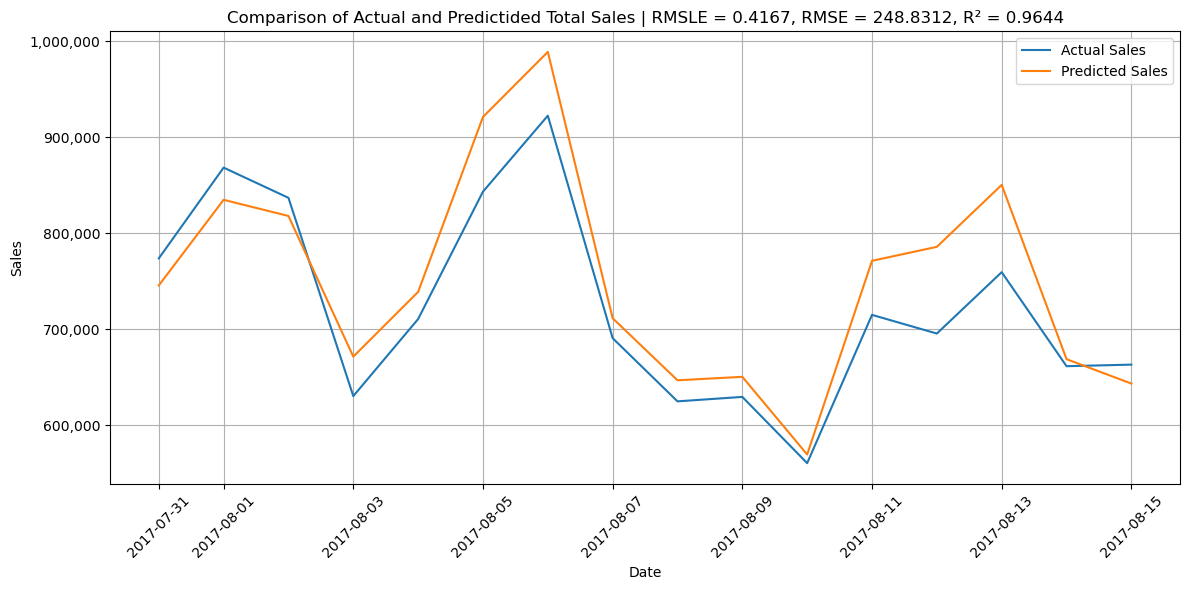

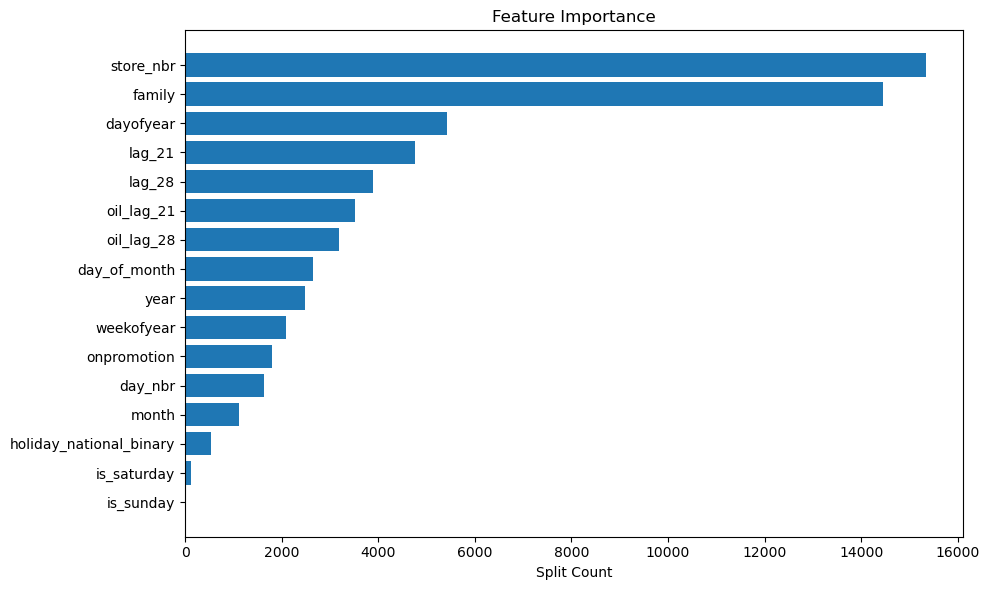

In [415]:
test_start='2017-07-31'
X_train = df_filtered[df_filtered['date']<test_start].copy()
y_train = y[y['date']<test_start].copy()

X_val = df_filtered[df_filtered['date']>=test_start].copy()
y_val = y[y['date']>=test_start].copy()
dates_val = y_val['date']


y_train = y_train['sales']
y_val = y_val['sales']

X_train = X_train[features]
X_val = X_val[features]

y_train = np.log1p(y_train)
y_val = np.log1p(y_val)

categorical_features = ['store_nbr','family']
cat_cols = ['store_nbr','family']
for col in cat_cols:
    X_train[col] = X_train[col].astype('category')
    X_val[col] = X_val[col].astype('category')

model = LGBMRegressor(
    objective='regression',
    boosting_type='gbdt',
    num_leaves=64,
    max_depth=7,
    learning_rate=0.05,
    n_estimators=1000,
    random_state=1,
)

model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='rmse',
    categorical_feature=['store_nbr', 'family'],
    callbacks=[early_stopping(stopping_rounds=50), log_evaluation(period=100)]
)
y_pred = model.predict(X_val)

y_pred = np.expm1(y_pred)
y_val = np.expm1(y_val)

y_pred = np.maximum(0, y_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
rmsle = np.sqrt(mean_squared_log_error(y_val, np.maximum(0, y_pred)))
r2= r2_score(y_val, np.maximum(0, y_pred))
mape = calculate_mape(y_val, np.maximum(0, y_pred))
rmsle
rmse
r2

df_plot = pd.DataFrame({
    'date': dates_val,
    'actual': y_val,
    'predicted': y_pred
})

daily_summary = df_plot.groupby('date')[['actual', 'predicted']].sum().reset_index()
plt.figure(figsize=(12, 6))
plt.plot(daily_summary['date'], daily_summary['actual'], label='Actual Sales')
plt.plot(daily_summary['date'], daily_summary['predicted'], label='Predicted Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title(f"Comparison of Actual and Predictided Total Sales | RMSLE = {rmsle:.4f}, RMSE = {rmse:.4f}, R² = {r2:.4f}")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.gca().yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))
plt.tight_layout()
plt.show()

# Feature importance (split count)
importance_df = pd.DataFrame({
    'feature': model.feature_name_,
    'importance': model.feature_importances_
}).sort_values(by='importance', ascending=True)

# Horizontal bar plot
plt.figure(figsize=(10, 6))
plt.barh(importance_df['feature'], importance_df['importance'])
plt.xlabel('Split Count')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

In [ ]:
calculate_mape(y_val, np.maximum(0, y_pred))

In [ ]:
rmse

In [ ]:
test_df_filtered = test_df[test_df['unique_id'].isin(features_to_keep)].copy()
features = [
 'onpromotion',
 'day_nbr',
 'day_of_month',
 'year',
 'month',
 'holiday_national_binary',
 'lag_21',
 'lag_28',
 'oil_lag_21',
 'oil_lag_28',
 'is_saturday',
 'is_sunday',
 'weekofyear',
 'dayofyear',
 'store_nbr',
 'family']
pred_data= test_df_filtered[features].copy()
cat_cols = ['store_nbr','family']
for col in cat_cols:
    pred_data[col] =  pred_data[col].astype('category')
    pred_data[col] =  pred_data[col].astype('category')

In [ ]:
y_pred = model.predict(pred_data)

In [ ]:
y_pred = np.expm1(y_pred)

In [ ]:
test_df_filtered = test_df_filtered.copy()
test_df_filtered['predicted_sales'] = y_pred

In [ ]:
total_predictions = test_df_filtered.groupby('date')['predicted_sales'].sum().reset_index()


In [ ]:

daily_summary_pred = test_df_filtered.groupby('date')[['predicted_sales']].sum().reset_index()
# plt.figure(figsize=(12, 6))
# plt.plot(daily_summary_pred['date'], daily_summary_pred['predicted_sales'], label='Προβλεπόμενες Πωλήσεις')

# plt.xlabel('Date')
# plt.ylabel('Sales')
# plt.title('Predicted Total Daily Sales')
# plt.legend()
# plt.xticks(rotation=45)
# plt.grid(True)
# plt.tight_layout()
# plt.show()


In [ ]:
# Rename the prediction-only DataFrame
daily_summary_pred = daily_summary_pred.rename(columns={'predicted_sales': 'predicted'})
daily_summary_pred['actual'] = np.nan  # no actuals for this period
combined = pd.concat([daily_summary, daily_summary_pred], axis=0).sort_values('date').reset_index(drop=True)

# plt.figure(figsize=(12, 6))

# # First: Actuals in blue (default)
# plt.plot(combined['date'], combined['actual'], label='Πραγματικές Πωλήσεις')

# # Second: Predictions in orange (second default color)
# plt.plot(combined['date'], combined['predicted'], label='Προβλεπόμενες Πωλήσεις', linestyle='--')

# plt.xlabel('Ημερομηνία')
# plt.ylabel('Πωλήσεις')
# plt.title('Πραγματικές και Προβλεπόμενες Ημερήσιες Πωλήσεις')
# plt.legend()
# plt.xticks(rotation=45)
# plt.grid(True)
# plt.tight_layout()
# plt.show()



In [ ]:
# Σημείο αλλαγής (π.χ. τέλος validation)
cutoff_date = pd.to_datetime('2017-08-15')

# Προβλέψεις εντός validation (κανονική γραμμή)
mask_val = combined['date'] <= cutoff_date
# Προβλέψεις μετά (προβλέψεις μέλλοντος — διακεκομμένη)
mask_future = combined['date'] > cutoff_date


In [ ]:
# Σημείο αλλαγής (π.χ. τέλος validation)
cutoff_date = pd.to_datetime('2017-08-15')

# Προβλέψεις εντός validation (κανονική γραμμή)
mask_val = combined['date'] <= cutoff_date
# Προβλέψεις μετά (προβλέψεις μέλλοντος — διακεκομμένη)
mask_future = combined['date'] > cutoff_date

plt.figure(figsize=(12, 6))

# Πραγματικές πωλήσεις (μπλε)
plt.plot(combined['date'], combined['actual'], label='Actual Sales')

# Προβλέψεις εντός validation (πορτοκαλί, κανονική)
plt.plot(combined.loc[mask_val, 'date'], combined.loc[mask_val, 'predicted'],
         label='Predicted Sales', color='orange')

# Προβλέψεις μέλλοντος (πορτοκαλί, διακεκομμένη)
plt.plot(combined.loc[mask_future, 'date'], combined.loc[mask_future, 'predicted'],
         linestyle='--', color='orange')

plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Actual and Predicted Total Sales')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.gca().yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))
plt.tight_layout()
plt.show()

In [ ]:
#XGBoost

In [ ]:
original = df.copy()

In [ ]:
# df = df[~df['unique_id'].isin(zero_sales['unique_id'])]
# df= df.drop(event_cols,axis=1)

In [ ]:
df.head()

In [ ]:
y = df[['date','sales']]
features = [
 'onpromotion',
 'day_nbr',
 'day_of_month',
 'year',
 'month',
 'holiday_national_binary',
 'lag_21',
 'lag_28',
 'oil_lag_21',
 'oil_lag_28',
 'is_saturday',
 'is_sunday',
 'weekofyear',
 'dayofyear',
 'store_nbr',
 'family']
 #'rolling_mean_7',                            # αυτα ειναι ολα τα features που τεσταρα αλλα τελικα δεν κρατησα
 #'rolling_mean_14',
 #'rolling_std_7',
 #'oil_lag_1',
 #'lag_7',
 #'family',                                  
 #'is_weekend',
 #'store_nbr',
 #'city',
 #'state',
 #'type',
 #'cluster',
 #'quarter',
 #'holiday_local_binary',
 #'holiday_regional_binary',
 #'lag_1',
 #'trans_lag_1',                                    # Αυτα ηταν lags για τα transactions
 #'trans_lag_7',
 #'trans_lag_14'

X = df[features].copy()

In [ ]:
test_start='2017-07-31'
X_train = df[df['date']<test_start].copy()
y_train = y[y['date']<test_start].copy()

X_val = df[df['date']>=test_start].copy()
y_val = y[y['date']>=test_start].copy()
dates_val = y_val['date']
y_train = y_train['sales']
y_val = y_val['sales']


X_train = X_train[features]
X_val = X_val[features]

# clip_threshold = y_train.quantile(0.995)
# y_train = y_train.clip(upper=clip_threshold)
# y_val= y_val.clip(upper=clip_threshold)

cat_cols = ['family','store_nbr']
for col in cat_cols:
    X_train[col] = X_train[col].astype('category')
    X_val[col] = X_val[col].astype('category')

reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree', 
                        enable_categorical=True,  
                        n_estimators=1000,
                        early_stopping_rounds=50,
                        objective='reg:linear',
                        max_depth=7,
                        learning_rate=0.05,
                        random_state=1
                        )
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        verbose=100)

y_pred = reg.predict(X_val)
y_val_clipped = np.maximum(y_val, 0)
y_pred_clipped = np.maximum(y_pred, 0)

r2 = r2_score(y_val, y_pred)
rmsle = np.sqrt(mean_squared_log_error(y_val_clipped, y_pred_clipped))
rmse = np.sqrt(mean_squared_error(y_val_clipped, y_pred_clipped))


df_plot = pd.DataFrame({
    'date': dates_val,
    'actual': y_val,
    'predicted': y_pred
})
daily_summary = df_plot.groupby('date')[['actual', 'predicted']].sum().reset_index()
plt.figure(figsize=(12, 6))
plt.plot(daily_summary['date'], daily_summary['actual'], label='Actual Sales')
plt.plot(daily_summary['date'], daily_summary['predicted'], label='Predicted Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title(f"Comparison of Actual and Predictided Total Sales | RMSLE = {rmsle:.4f}, RMSE = {rmse:.4f}, R² = {r2:.4f}")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.gca().yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))
plt.tight_layout()
plt.show()

# Feature importance (split count)
importance_df = pd.DataFrame({
    'feature': reg.get_booster().feature_names,
    'importance': reg.feature_importances_
}).sort_values(by='importance', ascending=True)

# Horizontal bar plot
plt.figure(figsize=(10, 6))
plt.barh(importance_df['feature'], importance_df['importance'])
plt.xlabel('Split Count')
plt.title('Feature Importance (XGBoost)')
plt.tight_layout()
plt.show()


In [ ]:
features = [
 'onpromotion',
 'day_nbr',
 'day_of_month',
 'year',
 'month',
 'holiday_national_binary',
 'lag_21',
 'lag_28',
 'oil_lag_21',
 'oil_lag_28',
 'is_saturday',
 'is_sunday',
 'weekofyear',
 'dayofyear',]

In [ ]:
def find_params_xgb(serie):
    #Extracting the series and formating so that the model has all the features
    category_df = total_sales_df[serie].copy().reset_index()
    temp = df[df['unique_id'] == serie].copy()
    category_df.columns = ["date", "sales"]

    temp = temp.drop(['id', 'store_nbr', 'family',
        'sales','city','state', 'type', 'cluster',
        'dcoilwtico', 'transactions','day','month_name',
        'holiday_national','holiday_regional',
        'holiday_local', 'event','unique_id'],axis=1)

    category_df["date"] = pd.to_datetime(category_df["date"])
    category_df= pd.merge(category_df,temp,on='date',how='left')
    category_df=category_df.drop_duplicates()
    category_df= category_df.drop_duplicates(subset=['date', 'sales'])
    category_df=category_df.dropna()

    y = category_df['sales']
    X = category_df[features].copy()
    #Grid search space
    param_grid = {
                'max_depth': [7],
                'learning_rate': [0.05,0.1],
                'n_estimators': [1000],
                'colsample_bytree': [0.7, 1.0],
                'min_child_weight': [1, 5, 10],
                'gamma': [0, 1],}
    

    xgb_reg = xgb.XGBRegressor()
    
    #Cross validation
    tscv = TimeSeriesSplit(n_splits=6, test_size=16)

    grid = GridSearchCV(estimator=xgb_reg,
                        param_grid=param_grid,
                        cv=tscv,
                        scoring='neg_root_mean_squared_error',
                        verbose=0)
    grid.fit(X, y)

    best_params = grid.best_params_
    best_score = -grid.best_score_

    best_params_with_score = best_params.copy()
    best_params_with_score["rmse"] = best_score
    return best_params_with_score

In [ ]:
def make_preds_xgb(serie,dicts={}):
    category_df = total_sales_df[serie].copy().reset_index()
    temp = df[df['unique_id'] == serie].copy()
    category_df.columns = ["date", "sales"]

    temp = temp.drop(['id', 'store_nbr', 'family',
        'sales','city','state', 'type', 'cluster',
        'dcoilwtico', 'transactions','day','month_name',
        'holiday_national','holiday_regional',
        'holiday_local', 'event','unique_id'],axis=1)

    category_df["date"] = pd.to_datetime(category_df["date"])
    category_df= pd.merge(category_df,temp,on='date',how='left')
    category_df=category_df.drop_duplicates()
    category_df= category_df.drop_duplicates(subset=['date', 'sales'])
    category_df=category_df.dropna()

    y = category_df[['date', 'sales']]
    features= category_df.columns.tolist()[2:]

    test_start='2017-07-15'
    X_train = category_df[category_df['date']<test_start].copy()
    y_train = y[y['date']<test_start].copy()

    X_val = category_df[category_df['date']>=test_start].copy()
    y_val = y[y['date']>=test_start].copy()
    dates_val = y_val['date']

    y_train = y_train.drop(['date'],axis=1)
    y_val = y_val.drop(['date'],axis=1)

    X_train = X_train[features]
    X_val = X_val[features]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree', 
                            enable_categorical=True,  
                            n_estimators=dicts['n_estimators'],
                            early_stopping_rounds=50,
                            objective='reg:linear',
                            max_depth=dicts['max_depth'],
                            learning_rate=dicts['learning_rate'],
                            colsample_bytree = dicts['colsample_bytree'],
                            min_child_weight= dicts['min_child_weight'],
                            gamma=dicts['gamma'],
                            random_state=1)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],
            verbose=100)

    y_pred = reg.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    rmsle = np.sqrt(mean_squared_log_error(y_val, np.maximum(0, y_pred)))

    m=category_df['sales'].mean()
    temp1 = pd.DataFrame({
                "unique_id":[serie],
                "rmse":[rmse],
                "ymean": [m],
                "rmsle":[rmsle],
                })
    return temp1

In [ ]:
# for params in ParameterGrid(param_grid):
#     model = xgb.XGBRegressor(
#         base_score=0.5,
#         booster='gbtree',
#         enable_categorical=True,
#         objective='reg:linear',
#         early_stopping_rounds=50,
#         **params
#     )

#     model.fit(
#         X_train, y_train,
#         eval_set=[(X_val, y_val)],
#         verbose=0
#     )

#     preds = model.predict(X_val)
#     score = np.sqrt(mean_squared_error(y_val, preds))
#     print(f"Params: {params} --> RMSE: {score:.4f}")


In [ ]:
original = df.copy()


In [ ]:
df=df.rename({"date":"ds","sales":"y"},axis=1)

In [ ]:
df = df[['unique_id',
         'ds','y',
         'onpromotion',
         'year','month',
         'day_nbr',
         'holiday_national_binary',
         'holiday_regional_binary','holiday_local_binary',
         'lag_21','lag_28','oil_lag_21','oil_lag_28',
         'day_of_month','is_saturday','is_sunday','weekofyear','dayofyear']] 

In [ ]:
# df = df[['unique_id', 'ds', 'y']]  # Only id, timestamp, and target
horizon = 16

# Define the model
nhits = NHITS(
    h=horizon,
    input_size=365 * 3,
    loss=RMSE(),
    max_steps=1000,
    val_check_steps=50,
    random_seed=1,
    futr_exog_list =['onpromotion',
                    'year','month',
                    'day_nbr',
                    'holiday_national_binary',
                    'holiday_regional_binary','holiday_local_binary',
                    'lag_21','lag_28','oil_lag_21','oil_lag_28',
                    'day_of_month','is_saturday','is_sunday','weekofyear','dayofyear']
)

# Wrap in NeuralForecast
nf = NeuralForecast(models=[nhits], freq='D')

# Fit the model
nf.fit(df=df,val_size=horizon)

In [ ]:
import logging

import optuna
import ray.tune as tune
import torch

from neuralforecast import NeuralForecast
from neuralforecast.auto import AutoNHITS, AutoLSTM
from neuralforecast.losses.pytorch import MQLoss

In [ ]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
logging.getLogger('pytorch_lightning').setLevel(logging.ERROR)
torch.set_float32_matmul_precision('high')

In [ ]:
def config_nhits(trial):
    return {
        "input_size": trial.suggest_categorical(          # Length of input window
            "input_size", (48, 48*2, 48*3)                
        ),                                                
        "start_padding_enabled": True,                                          
        "n_blocks": 5 * [1],                              # Length of input window
        "mlp_units": 5 * [[64, 64]],                      # Length of input window
        "n_pool_kernel_size": trial.suggest_categorical(
            "n_pool_kernel_size",
            ((1, 1, 1, 1, 1), (2, 2, 2, 2, 2), (4, 4, 4, 4, 4), (8, 4, 2, 1, 1))
        )
        ,     
        "n_freq_downsample": trial.suggest_categorical(   # Interpolation expressivity ratios
            "n_freq_downsample",
            ([8, 4, 2, 1, 1],  [1, 1, 1, 1, 1])
        ),     
        "learning_rate": trial.suggest_float(             # Initial Learning rate
            "learning_rate",
            low=1e-4,
            high=1e-2,
            log=True,
        ),            
        "scaler_type": None,                              # Scaler type
        "max_steps": 1000,                                # Max number of training iterations
        "batch_size": trial.suggest_categorical(          # Number of series in batch
            "batch_size",
            (1, 4, 10),
        ),                   
        "windows_batch_size": trial.suggest_categorical(  # Number of windows in batch
            "windows_batch_size",
            (128, 256, 512),
        ),      
        "random_seed": trial.suggest_int(                 # Random seed   
            "random_seed",
            low=1,
            high=20,
        
        ),                      
    }

In [ ]:
import logging

import optuna
import ray.tune as tune
import torch

from neuralforecast import NeuralForecast
from neuralforecast.auto import AutoNHITS, AutoLSTM
from neuralforecast.losses.pytorch import MQLoss

In [ ]:
nf = NeuralForecast(
    models=[
        AutoModel(model_class=NHITS, h=48, config=config_nhits, loss=MQLoss(), backend='optuna', num_samples=5),
        AutoModel(model_class=LSTM,  h=48, config=config_lstm,  loss=MQLoss(), backend='optuna', num_samples=2),
    ],
    freq='D',
)

In [ ]:
nf.fit(df=df)

In [ ]:
fcst_df = nf.predict()
fcst_df.columns = fcst_df.columns.str.replace('-median', '')
plot_series(df, fcst_df, plot_random=False, max_insample_length=16*3, level=[80, 90])


In [ ]:
cv_df = nf.cross_validation(df, n_windows=2)
cv_df.columns = cv_df.columns.str.replace('-median', '')

In [ ]:
for cutoff in cv_df['cutoff'].unique():
    display(
        plot_series(
            df,
            cv_df.query('cutoff == @cutoff').drop(columns=['y', 'cutoff']),
            max_insample_length=16 * 4,
            ids=['44_BEVERAGES']))